In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

(299, 2)


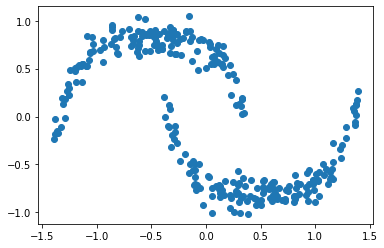

In [2]:
toy_data = np.array(pd.read_csv("realnvp_toydata.csv"))
print(toy_data.shape)
plt.scatter(toy_data[:,0],toy_data[:,1])
plt.savefig("Figure/toy_data_plot.png")

In [3]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, n_hidden = 32, permute = False):
        super().__init__()
        self.n_channel,self.n_split, self.permute = 2, 1, permute
        self.nn = nn.Sequential(
            nn.Linear(self.n_split, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 2*(self.n_split))
        )
    def forward(self, x):
        # x: bxc
        b,c = x.shape
        assert self.n_channel == c
        remain, change = None, None
        if self.permute:
            remain, change = x[:,:self.n_split], x[:,self.n_split:]
        else:
            remain, change = x[:,self.n_split:], x[:,:self.n_split]
        nn_result = self.nn(remain) #bx2(D-d)
        #log_s, t: bx(D-d)
        log_s, t = nn_result[:,0::2], nn_result[:,1::2]
        # s = torch.exp(log_s) #log_s는 initially 0
        s = torch.exp(F.tanh(log_s))
        y_remain, y_change = remain, s*change + t
        y = None
        if self.permute:
            y = torch.cat((y_remain, y_change), dim = 1)
        else:
            y = torch.cat((y_change, y_remain), dim = 1)
        log_det = s.view(b, -1).abs().log().sum(dim = 1)

        return y, log_det
    def reverse(self, z):
        # z: bxcxhxw
        remain, change = None, None
        if self.permute:
            remain, change = z[:,:self.n_split], z[:,self.n_split:]
        else:
            remain, change = z[:,self.n_split:], z[:,:self.n_split]
        nn_result = self.nn(remain) #bx2(D-d) x h x w
        log_s, t = nn_result[:,0::2], nn_result[:,1::2]
        s = torch.exp(F.tanh(log_s))
        y_remain, y_change = remain, (change-t)/s
        y = None
        if self.permute:
            y = torch.cat((y_remain, y_change), dim = 1)
        else:
            y = torch.cat((y_change, y_remain), dim = 1)
        return y


In [4]:
b, c = 4, 2
x = torch.randn(b,c)
model = AffineCouplingLayer(n_hidden= 64)
z, log_det = model(x)
x2 = model.reverse(z)
#check invertible
assert torch.allclose(x, x2, atol = 1e-7)


In [5]:
class RealNVP(nn.Module):
    def __init__(self, n_flow, n_hidden):
        super().__init__()
        self.affines = nn.ModuleList([AffineCouplingLayer(n_hidden = n_hidden, permute = idx%2 == 0) for idx in range(n_flow)])
    def forward(self, x):
        output, log_det = x, 0
        for layer in self.affines:
            output, log_det_ = layer(output)
            log_det += log_det_
        return output, log_det
    def reverse(self, z):
        output = z
        for layer in self.affines[::-1]:
            output = layer.reverse(output)
        return output

In [6]:
b, c = 300, 2
x = torch.randn(b,c)
model = RealNVP(n_hidden = 100, n_flow = 10)
z, log_det = model(x)
x2 = model.reverse(z)
#check invertible
assert torch.allclose(x, x2, atol = 1e-7)


In [29]:
def draw_figure(x, x2z, z, z2x, ep):
    plt.figure(figsize= (12,12))
    plt.subplot(2,2,1)
    plt.title("x")
    plt.scatter(x[:,0], x[:,1])
    plt.subplot(2,2,2)
    plt.title("x -> z")
    plt.scatter(x2z[:,0], x2z[:,1])
    plt.subplot(2,2,3)
    plt.title("z")
    plt.scatter(z[:,0], z[:,1])
    plt.subplot(2,2,4)
    plt.title("z -> x")
    plt.scatter(z2x[:,0], z2x[:,1])
    plt.savefig(f"Toy_samples/{ep}.png", facecolor ="white")
    plt.clf()

In [32]:
from torch.optim import Adam
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from time import time
import shutil, os

shutil.rmtree("Toy_samples")
os.mkdir("Toy_samples")

train_data = torch.tensor(toy_data, dtype = torch.float)

model = RealNVP(n_hidden = 128, n_flow = 8)
optimizer = Adam(model.parameters(), lr = 1e-4)

train_loss_arr = []
prior_arr = []
n_iter = 0
for ep in range(280):
    model.train()
    start = time()
    batch_size = train_data.shape[0]
    optimizer.zero_grad()
    output, log_det = model(train_data)
    loss_prior = ((output ** 2+ np.log(2 * np.pi))/2).sum(dim = 1)
    loss = loss_prior - log_det
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    n_iter += 1
    train_loss_arr.append(loss.item())
    prior_arr.append(loss_prior.mean().item())
    model.eval()
    with torch.no_grad():
        z = torch.randn(299, 2)
        generated = model.reverse(z)
    draw_figure(train_data.numpy(), output.detach().numpy(), z.numpy(), generated.numpy(), ep)
    print(f"[{ep}] train_loss: {loss.item():.4f}, loss_prior: {loss_prior.mean().item():.4f}")


[0] train_loss: 2.3240, loss_prior: 2.9569
[1] train_loss: 2.2469, loss_prior: 2.8641
[2] train_loss: 2.1807, loss_prior: 2.7953
[3] train_loss: 2.1225, loss_prior: 2.7453
[4] train_loss: 2.0703, loss_prior: 2.7106
[5] train_loss: 2.0228, loss_prior: 2.6886
[6] train_loss: 1.9794, loss_prior: 2.6776
[7] train_loss: 1.9397, loss_prior: 2.6763
[8] train_loss: 1.9038, loss_prior: 2.6837
[9] train_loss: 1.8716, loss_prior: 2.6989
[10] train_loss: 1.8433, loss_prior: 2.7209
[11] train_loss: 1.8190, loss_prior: 2.7490
[12] train_loss: 1.7987, loss_prior: 2.7821
[13] train_loss: 1.7823, loss_prior: 2.8183
[14] train_loss: 1.7692, loss_prior: 2.8558
[15] train_loss: 1.7593, loss_prior: 2.8925
[16] train_loss: 1.7517, loss_prior: 2.9262
[17] train_loss: 1.7456, loss_prior: 2.9548
[18] train_loss: 1.7402, loss_prior: 2.9766
[19] train_loss: 1.7346, loss_prior: 2.9905
[20] train_loss: 1.7281, loss_prior: 2.9957
[21] train_loss: 1.7202, loss_prior: 2.9922
[22] train_loss: 1.7109, loss_prior: 2.981

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [35]:
torch.save(model.state_dict(),"Toy_samples/pretrained.pth")

In [1]:
z = torch.randn(1000, 2)
loss_prior = ((z ** 2+ np.log(2 * np.pi))/2).sum(dim = 1).mean().item()

plt.plot(train_loss_arr, 'g')
plt.plot(prior_arr, 'b')
plt.axhline(y = loss_prior,  color= 'r', linestyle = "-")
plt.legend(['NLL', '-logP', 'exact logP'])
plt.savefig("Toy_samples/loss_plot.png")

NameError: name 'torch' is not defined